<a href="https://colab.research.google.com/github/BurnhamG/ml_projects/blob/master/Pet_Identification_with_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet recognition using Inception

In [0]:
# Options
batch_size = 64
train_test_split = 0.9
layer_split = 20

In [0]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
import pathlib
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import re
import math
import numpy as np
from keras import backend as K

In [35]:
tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(AUTOTUNE, tf.VERSION)

-1 1.15.0


In [0]:
# More advanced logging
# https://stackoverflow.com/questions/40559667/how-to-redirect-tensorflow-logging-to-a-file
import logging

# get TF logger
log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
fh = logging.FileHandler('tensorflow.log')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

In [0]:
# Uses local copy instead of redownloading the data every time
if not os.path.exists("/gdrive"):
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive

    !mkdir -p /root/.keras/datasets
    if not os.path.exists('/root/.keras/datasets/images.tar.gz'):
        !cp /gdrive/My\ Drive/images.tar.gz /root/.keras/datasets/

In [0]:
# Load data
os.chdir("/root/.keras/datasets/")
if not os.path.exists('/root/.keras/datasets/images'):
    !mkdir -p images
# Check if mounting Google drive failed, or if the file doesn't exist
if not os.path.exists("/gdrive") or not os.path.exists('/root/.keras/datasets/images.tar.gz'):
    data_loc = tf.keras.utils.get_file('images.tar.gz', origin="http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz")
else:
    data_loc = pathlib.Path("/root/.keras/datasets/images.tar.gz")
path_img = pathlib.Path("/root/.keras/datasets/images/")
if len(list(path_img.glob('.jpg'))) == 0:
    !tar xzf {data_loc}
all_images = [str(i) for i in path_img.glob('*.jpg')]

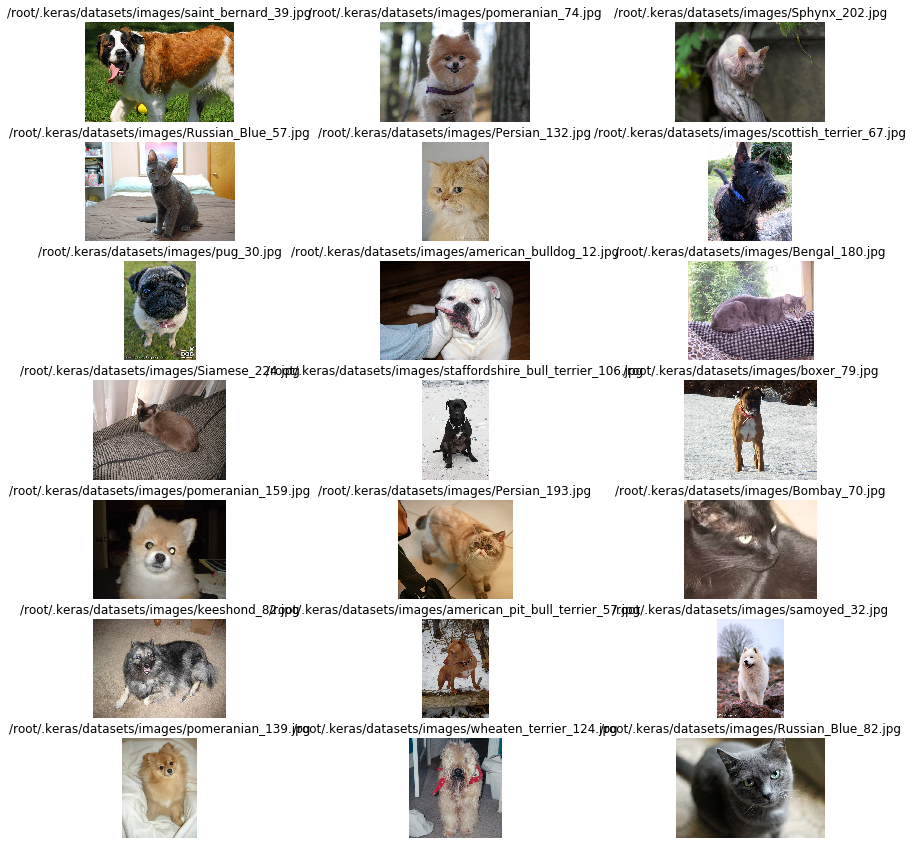

In [39]:
# Get the index for splitting the data
    split = int(len(all_images)*train_test_split)
    
    def show_images_grid(images_list, cols=3, figsize=(10,15), file_name=False):
        """ Displays images in a grid """
        num_imgs = len(images_list)
        rows = num_imgs // cols + 1 if num_imgs % cols != 0 else num_imgs // cols
        fig = plt.figure(figsize=figsize)
        i = 1
        for img in images_list:
            a = fig.add_subplot(rows, cols, i)
            i += 1
            plt.imshow(imread(img))
            plt.axis('off')
            if file_name:
                plt.title(str(img))


    # Show first 21 images
    show_images_grid(all_images[:21], figsize=(15,15),file_name=True)

    # Get labels from file names 
    regex = re.compile(r'/([^/]+)_\d+.jpg$')

    all_labels = [res.group(1) for img in all_images for res in (regex.search(img),)if res]

    # Shuffle the data
    c = list(zip(all_images, all_labels))
    random.shuffle(c)
    all_images, all_labels = zip(*c)
    all_images = list(all_images)
    all_labels = list(all_labels)

    label_names = list(set(all_labels))
    
    label_to_index = dict((name, idx) for idx, name in enumerate(label_names))
    
    all_image_labels = [label_to_index[x[1]] for x in zip(all_images, all_labels)]
    
    # Split into sets
    train_data = all_images[:split]
    train_labels = all_image_labels[:split]
    validation_data = all_images[split:]
    validation_labels = all_image_labels[split:]

In [0]:
# Image preprocessing and data augmentation
image_size = 224

def preprocess_image(image):
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize_images(image, [image_size,image_size])
    image /= 255.0
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

def flip_image(image):
    image = tf.image.random_flip_left_right(image)
    return image


def rotate_image(image):
    choice = tf.random_uniform(shape=[], minval=0., maxval=1.)
    rotation_amt = tf.random_uniform(shape=[],
                                        minval=-10*math.pi/180,
                                        maxval=10*math.pi/180
                                    )
    image = tf.cond(choice < 0.25, lambda : image,
                    lambda: tf.contrib.image.rotate(image, rotation_amt)
                    )
    return image
    
    
def change_lighting(image):
    choice2 = tf.random_uniform(shape=[], minval=0., maxval=1.)
    
    def brightness(img):
        img = tf.image.random_brightness(image, 0.2)
        return img
    
    image = tf.cond(choice2 < 0.25, lambda: image,
                    lambda: tf.image.random_contrast(brightness(image), 0.8, 1.2)
                    )
    image = tf.clip_by_value(image,0,1)
    return image


def zoom_image(image):
    choice3 = tf.random_uniform(shape=[], minval=0., maxval=1.)
    
    def random_crop(img):
        scale = tf.random_uniform([], minval=0.9, maxval=1.0, dtype=tf.float32)
        boxes = np.zeros((1, 4))
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes = [x1, y1, x2, y2]
        img = tf.image.crop_and_resize([img], boxes=[boxes], box_indices=np.zeros(1), crop_size=(image_size, image_size))
        return img[0]
    
    image = tf.cond(choice3 < 0.25, lambda: image, lambda: random_crop(image))
    image = tf.clip_by_value(image,0,1)
    return image


def augment_image(image):
    # Augmentations from https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
    image = flip_image(image)
    image = change_lighting(image)
    image = rotate_image(image)
    image = zoom_image(image)
    return image

def show_images(image_ds, number=8):
    if tf.executing_eagerly():
        plt.figure(figsize=(8,8))
        rows = number // 2
        cols = math.ceil(number / rows)
        for n,image in enumerate(image_ds.take(number)):
            plt.subplot(rows,cols,n+1)
            plt.imshow(image)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            if dataset == 'pets':
                plt.xlabel(label_names[all_image_labels[n]])

In [41]:
# Dataset of paths
path_ds = tf.data.Dataset.from_tensor_slices(train_data)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)
# Iterate over paths, loading and preprocessing the data
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
image_rec_ds = image_ds.map(tf.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_rec_ds)

RESTORE_TYPE = image_ds.output_types
RESTORE_SHAPE = image_ds.output_shapes

image_ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
    result = tf.parse_tensor(x, out_type=RESTORE_TYPE)
    result = tf.reshape(result, RESTORE_SHAPE)
    return result

image_ds = image_ds.map(parse, num_parallel_calls=AUTOTUNE)

# Augment the dataset
for aug in [flip_image, rotate_image, change_lighting, zoom_image]:
        image_ds = image_ds.map(aug, num_parallel_calls=AUTOTUNE)

In [0]:
# Create label dataset
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int32))

In [0]:
# Clear dataset caches
!rm -rf /content/*.tf-data*

In [0]:
train_image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [46]:
train_ds = train_image_label_ds.cache(filename='/content/train.tf-data')
train_ds = train_ds.shuffle(buffer_size = len(train_data))
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
print(train_ds)

validation_ds = tf.data.Dataset.from_tensor_slices(validation_data)
validation_ds = validation_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

validation_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(validation_labels, tf.int32))


valid_ds = tf.data.Dataset.zip((validation_ds, validation_label_ds))
valid_ds = valid_ds.cache(filename='/content/valid.tf-data')
# valid_ds = valid_ds.shuffle(buffer_size = len(validation_data))
valid_ds = valid_ds.repeat()
valid_ds = valid_ds.batch(batch_size)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
print(valid_ds)

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>


In [47]:
# Get base model and set trainable layers
pre_model = tf.keras.applications.InceptionV3(input_shape=(image_size, image_size, 3), include_top=False)

print("Base pre-trained model trainable weights:", len(pre_model.trainable_weights))
for layer in pre_model.layers[:-layer_split]:
    layer.trainable = False
for layer in pre_model.layers[-layer_split:]:
    layer.trainable = True

print("Updated pre-trained model trainable weights:", len(pre_model.trainable_weights))

# Get output layer
pre_out = pre_model.get_layer('mixed10').output

Base pre-trained model trainable weights: 188
Updated pre-trained model trainable weights: 10


In [0]:
classes = len(label_names)
phase = K.learning_phase()

# Pool output layer twice, then concatenate
z = layers.GlobalAvgPool2D()((pre_out))
y = layers.GlobalMaxPool2D()((pre_out))
x = layers.concatenate([z, y])

x = layers.Flatten()(x)
x = layers.BatchNormalization(axis=1, momentum=.9, epsilon=1e-5, trainable=phase,)(x)
x = layers.Dropout(rate=.25)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization(axis=1, momentum=.9, epsilon=1e-5, trainable=phase)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(classes, activation='softmax')(x)

model = Model(pre_model.input, x)

In [0]:
# Same model, but with l2 regularization

z = layers.GlobalAvgPool2D()((pre_out))
y = layers.GlobalMaxPool2D()((pre_out))
x = layers.concatenate([z, y])

x = layers.Flatten()(x)
x = layers.BatchNormalization(trainable=phase)(x)
x = layers.Dropout(rate=.25,)(x)
x = layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.1))(x)
x = layers.ReLU()(x)
x = layers.BatchNormalization(trainable=phase)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(classes, activation='softmax')(x)

model_l2r = Model(pre_model.input, x)

In [0]:
loss_func = tf.keras.losses.sparse_categorical_crossentropy

model.compile(optimizer=tf.train.AdamOptimizer(),
             loss=loss_func,
             metrics=["accuracy"])

model_l2r.compile(optimizer=tf.train.AdamOptimizer(),
             loss=loss_func,
             metrics=["accuracy"])

In [0]:
train_steps_per_epoch=int(tf.ceil(len(train_data)/ batch_size).numpy())
valid_steps_per_epoch = int(tf.ceil(len(validation_data)/batch_size).numpy())

In [52]:
history = model.fit_generator(train_ds, epochs=4, steps_per_epoch=train_steps_per_epoch,validation_data=valid_ds,validation_steps=valid_steps_per_epoch,verbose=1, )

Epoch 1/4
104/104 [==============================] - 105s 1s/step - loss: 1.2432 - acc: 0.6618 - val_loss: 1.6387 - val_acc: 0.7292
Epoch 2/4
104/104 [==============================] - 39s 377ms/step - loss: 0.5156 - acc: 0.8371 - val_loss: 1.3277 - val_acc: 0.7982
Epoch 3/4
104/104 [==============================] - 39s 376ms/step - loss: 0.2961 - acc: 0.9022 - val_loss: 1.0711 - val_acc: 0.8216
Epoch 4/4
104/104 [==============================] - 39s 377ms/step - loss: 0.1959 - acc: 0.9340 - val_loss: 1.3039 - val_acc: 0.8047


In [53]:
history_l2r = model_l2r.fit_generator(train_ds, epochs=4, steps_per_epoch=train_steps_per_epoch,validation_data=valid_ds,validation_steps=valid_steps_per_epoch,verbose=1, )

Epoch 1/4
104/104 [==============================] - 73s 701ms/step - loss: 20.4743 - acc: 0.7350 - val_loss: 4.5987 - val_acc: 0.5755
Epoch 2/4
104/104 [==============================] - 39s 376ms/step - loss: 3.5528 - acc: 0.8235 - val_loss: 4.6937 - val_acc: 0.6094
Epoch 3/4
104/104 [==============================] - 39s 378ms/step - loss: 3.3752 - acc: 0.8424 - val_loss: 4.3259 - val_acc: 0.5990
Epoch 4/4
104/104 [==============================] - 39s 376ms/step - loss: 3.1164 - acc: 0.8679 - val_loss: 4.6624 - val_acc: 0.5286


In [0]:
# Visualize the model
# keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [55]:
# Find model that is more accurate
if history.history['val_acc'][-1] > history_l2r.history['val_acc'][-1]:
    print('Vanilla model was more accurate!', history.history['val_acc'][-1])
    best_model = model
else:
    print('L2 regularization was more accurate!', history_l2r.history['val_acc'][-1])
    best_model = model_l2r

Vanilla model was more accurate! 0.8046875


In [0]:
choice = random.choice(validation_data)
choice_index = validation_data.index(choice)

choice = load_and_preprocess_image(choice)

choice = np.expand_dims(choice,0)

successive_outputs = [layer.output for layer in best_model.layers]

layer_names = [layer.name for layer in best_model.layers]

functor = Model(best_model.input, successive_outputs)

outs = functor(choice,training=K.learning_phase())

In [0]:
def show_layer_outputs(start_layer, end_layer):
    """
    Based on code from deeplearning.ai's Introduction to Tensorflow on Coursera.
    Displays the activations of each layer
    """
    for name, img in zip(layer_names[start_layer:end_layer], outs[start_layer:end_layer]):
        if len(img.shape) == 4:
            size = img.shape[1]
            feats = int(img.shape[-1])
            if feats > 16:
                num_rows = np.ceil(feats /16)
                display_grid = np.zeros((num_rows*size, size * 16))
            else:
                display_grid = np.zeros((size, size * feats))

            for i in range(feats):
                x = img[0,:,:,i].numpy()
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                row = i // 16
                col_start = i*size
                col_end = (i+1)*size
                if row > 0: 
                
                    col_start -= size * 16 * row
                    col_end -= size* 16 * row
                
                display_grid[size*row:size*(row+1),col_start:col_end] = x                
            scale = 40. / feats
            plt.figure(figsize=(30,scale*(row+1)*feats/16))
            plt.title(f"{name}, {feats} features")
            plt.axis(False)
            plt.grid(False)
            plt.imshow(display_grid, aspect='equal',cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


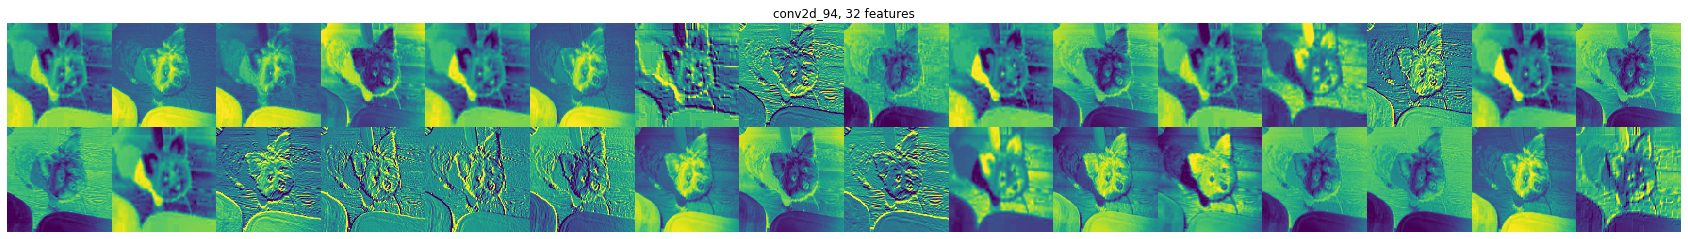

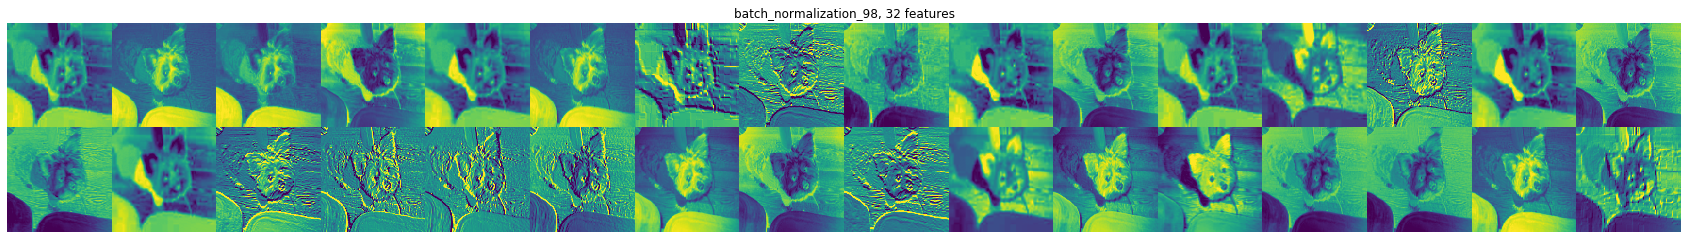

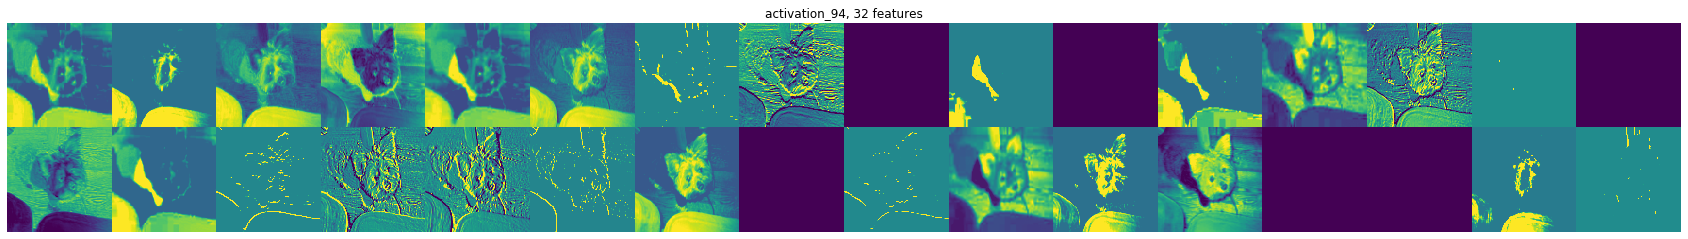

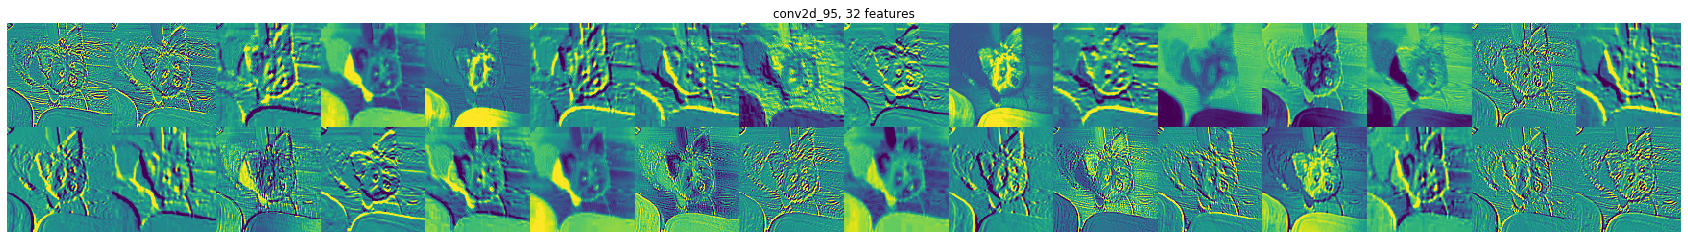

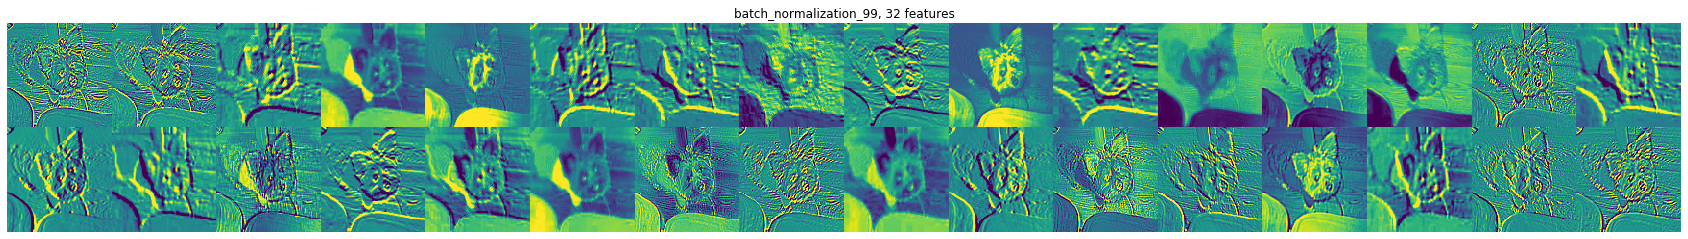

In [86]:
# Visualize layer outputs
total_layers = len(best_model.layers)

start = 1
end = 6

# View all activations
# while end <= total_layers:
# View first 5 activations
while end <= 6:
    show_layer_outputs(start,end)
    start = end
    if end < total_layers - 5 or end == total_layers:
        end += 5
    else:
        end = total_layers